## Library

In [185]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Dataset

In [186]:
df = pd.read_csv('data/LoadData.csv')
df.head()

,Date,N_Y_C_
0,05/01/2007 00:00:00,4854.400000
1,05/01/2007 00:15:00,4777.370779
2,05/01/2007 00:30:00,4729.483400
3,05/01/2007 00:45:00,4682.387550
4,05/01/2007 01:00:00,4587.337550


In [187]:
# Aggregating the dataset at daily level
df['Timestamp'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M:%S')
df.index = df['Timestamp']
df = df.resample('D').mean()
print(df)

                 N_Y_C_
Timestamp              
2007-05-01  5666.252902
2007-05-02  5666.180415
2007-05-03  5662.574479
2007-05-04  5615.351488
2007-05-05  5032.153638
...                 ...
2019-02-24  5144.902344
2019-02-25  5790.148177
2019-02-26  6000.704688
2019-02-27  6114.133594
2019-02-28  5978.750781

[4322 rows x 1 columns]


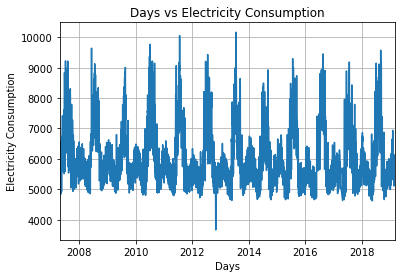

In [188]:
plt.title('Days vs Electricity Consumption')
plt.ylabel('Electricity Consumption')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['N_Y_C_'])

In [189]:
all_data = df['N_Y_C_'].values.astype(float)
print(all_data)

[5666.25290174 5666.18041492 5662.57447917 ... 6000.7046875  6114.13359375
 5978.75078125]


In [190]:
def sliding_windows(data, seq_length):
    '''
    window, label
    这个函数的目的是为了从原时间序列中抽取出训练样本，也就是用第1个值到第4个值作为X输入，预测第5个值作为y输出，
    这是一个用于训练的数据点，时间窗口向后滑动以此类推
    seq_length: 次の時間区間を予測するために入力変数として使用する前の時間ステップの数
    X(t) Y(t + seq_length)
    '''

    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

# Min/max进行标准化处理，默认范围0-1
sc = MinMaxScaler()
# 通过 fit_transform() 对数据集进行归一化
training_data = sc.fit_transform(all_data.reshape(-1, 1))
print(len(training_data))

# 分割序列窗口，实验表明越小可以学到更多细节
seq_length = 30
x, y = sliding_windows(training_data, seq_length)
print(len(x))
print(len(y))

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size
print(train_size)
print(test_size)


# 转换成 tensor
dataX = torch.Tensor(np.array(x)).float()
dataY = torch.Tensor(np.array(y)).float()

trainX = torch.tensor(np.array(x[0:train_size])).float()
trainY = torch.tensor(np.array(y[0:train_size])).float()

testX = torch.Tensor(np.array(x[train_size:len(x)])).float()
testY = torch.Tensor(np.array(y[train_size:len(y)])).float()

4322
4291
4291
2874
1417


## Model

In [191]:
class LSTMnetwork(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM
    
    input_size: 输入数据的大小，也就是前面例子中每个单词向量的长度
    hidden_size: 隐藏层的大小（即隐藏层节点数量），输出向量的维度等于隐藏节点数
    num_layers: recurrent layer的数量，默认等于1
    bias: If False, then the layer does not use bias weights b_ih and b_hh
    batch_first: 默认为False，也就是说官方不推荐我们把batch放在第一维，这个与之前常见的CNN输入有点不同，此时输入输出的各个维度含义为 (seq_length,batch,feature)
    dropout: 如果非0，就在除了最后一层的其它层都插入Dropout层，默认为0
    bidirectional: 如果设置为 True, 则表示双向 LSTM，默认为 False
    '''


    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMnetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        # 定义全连接层 num_classes(output_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        前向传播的过程是输入 -> LSTM层 -> 全连接层 -> 输出
        在观察查看LSTM输入的维度，LSTM的第一个输入input_size维度是(L, N, H_in), L是序列长度，N是batch size，H_in是输入尺寸，也就是变量个数
        LSTM的第二个输入是一个元组，包含了h0,c0两个元素，这两个元素的维度都是（D∗num_layers,N,H_out)，D=1表示单向网络，num_layers表示多少个LSTM层叠加，N是batch size，H_out表示隐层神经元个数
        '''
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Propagate input through LSTM
        out, (h_n, h_c) = self.lstm(x, (h0, c0))
        # 输出只用取最后一个值
        out = self.fc(out[:, -1, :])
        
        return out 

## Training

In [192]:
# 确定网络学习数据快慢，即权重的更新频率
# 1 Epoch = 1 Forward pass + 1 Backward pass for ALL training samples.
epochs = 2000
# x 的特征维度
input_size = 1
# 隐藏层的特征维度（一个LSTM内部中神经元的个数）
hidden_size = 2 
# lstm隐层的层数，默认为1
num_layers = 1
num_classes = 1
learning_rate = 0.01

# torch.manual_seed(1) 

model = LSTMnetwork(input_size, hidden_size, num_layers, num_classes)

# 度量与优化定义 损失函数=用MSE 优化算法=用ADAM
# mean-squared error for regression
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epochs):
    outputs = model(trainX)
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    # 每次更新参数前都梯度归零和初始化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("Epoch: [{}/{}], loss: {:.4f}"
              .format(epoch, epochs, loss.item()))

Epoch: [0/2000], loss: 0.2131
Epoch: [100/2000], loss: 0.0079
Epoch: [200/2000], loss: 0.0074
Epoch: [300/2000], loss: 0.0069
Epoch: [400/2000], loss: 0.0063
Epoch: [500/2000], loss: 0.0056
Epoch: [600/2000], loss: 0.0049
Epoch: [700/2000], loss: 0.0045
Epoch: [800/2000], loss: 0.0043
Epoch: [900/2000], loss: 0.0042
Epoch: [1000/2000], loss: 0.0042
Epoch: [1100/2000], loss: 0.0042
Epoch: [1200/2000], loss: 0.0041
Epoch: [1300/2000], loss: 0.0041
Epoch: [1400/2000], loss: 0.0041
Epoch: [1500/2000], loss: 0.0041
Epoch: [1600/2000], loss: 0.0041
Epoch: [1700/2000], loss: 0.0041
Epoch: [1800/2000], loss: 0.0040
Epoch: [1900/2000], loss: 0.0040


## Testing for electricity consumption dataset

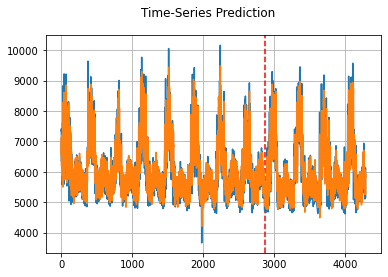

In [193]:
model.eval()
with torch.no_grad():
    test_predict = model(dataX)
    data_predict = test_predict.data.numpy()
    dataY_plot = dataY.data.numpy()

    # 逆归一化还原真实值
    data_predict = sc.inverse_transform(data_predict)
    dataY_plot = sc.inverse_transform(dataY_plot)

    
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.grid(True)
plt.suptitle('Time-Series Prediction')
plt.show()